In [31]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster
import matplotlib.pyplot as plt  
%matplotlib inline
import numpy as np  
from sklearn.cluster import KMeans  

In [2]:
df1=pd.read_csv('test2.csv')

In [3]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 5 columns):
Unnamed: 0     4222 non-null int64
Customer_ID    4222 non-null int64
Date           4222 non-null object
Amount         4222 non-null int64
frequency      4222 non-null int64
dtypes: int64(4), object(1)
memory usage: 165.0+ KB


In [4]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [5]:
df2=df1
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222 entries, 0 to 4221
Data columns (total 5 columns):
Unnamed: 0     4222 non-null int64
Customer_ID    4222 non-null int64
Date           4222 non-null datetime64[ns]
Amount         4222 non-null int64
frequency      4222 non-null int64
dtypes: datetime64[ns](1), int64(4)
memory usage: 165.0 KB


In [6]:
sd = dt.datetime(2018,12,31)

In [7]:
df2['hist']=sd - df2['Date']
df2['hist'].astype('timedelta64[D]')
df2['hist']=df2['hist'] / np.timedelta64(1, 'D')
df2.head()

,Unnamed: 0,Customer_ID,Date,Amount,frequency,hist
0,1,5496,2018-08-01,176688,4,152.0
1,2,5497,2018-09-01,248054,3,121.0
2,3,5498,2018-10-01,166980,2,91.0
3,4,5499,2018-11-01,227480,1,60.0
4,5,5500,2018-12-01,125067,2,30.0


In [8]:
max(df2['frequency'])

4

In [9]:
rfmTable = df2.groupby('Customer_ID').agg({'hist': lambda x:x.min(), # Recency
                                        'frequency' : lambda x: x,               # Frequency
                                        'Amount': lambda x: x.sum()})          # Monetary Value


In [10]:
rfmTable.head()

,hist,frequency,Amount
Customer_ID,,,
5496,152.0,4,176688
5497,121.0,3,248054
5498,91.0,2,166980
5499,60.0,1,227480
5500,30.0,2,125067


In [15]:
rfmTable.rename(columns={'hist': 'recent', 
                         'frequency': 'count', 
                         'Spent': 'spent'}, inplace=True)

In [16]:
rfmTable.head()

,recent,count,spent
Customer_ID,,,
5496,152.0,4,176688
5497,121.0,3,248054
5498,91.0,2,166980
5499,60.0,1,227480
5500,30.0,2,125067


In [17]:
quartiles = rfmTable.quantile(q=[0.25,0.50,0.75])

In [18]:
quartiles=quartiles.to_dict()
quartiles

{'count': {0.25: 1.0, 0.5: 2.0, 0.75: 3.0},
 'recent': {0.25: 207.0, 0.5: 439.0, 0.75: 763.0},
 'spent': {0.25: 85316.5, 0.5: 104644.5, 0.75: 129185.75}}

In [19]:
def RClass(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FMClass(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1    
    

In [23]:
rfmSeg = rfmTable
rfmSeg['R_Quartile'] = rfmSeg['recent'].apply(RClass, args=('recent',quartiles,))
rfmSeg['F_Quartile'] = rfmSeg['count'].apply(FMClass, args=('count',quartiles,))
rfmSeg['M_Quartile'] = rfmSeg['spent'].apply(FMClass, args=('spent',quartiles,))

In [24]:
rfmSeg['RCSClass'] = rfmSeg.R_Quartile.map(str) \
                            + rfmSeg.F_Quartile.map(str) \
                            + rfmSeg.M_Quartile.map(str)

In [53]:
rfmSeg.head()

,recent,count,spent,R_Quartile,F_Quartile,M_Quartile,RCSClass
Customer_ID,,,,,,,
5496,152.0,4,176688,1,1,1,111
5497,121.0,3,248054,1,2,1,121
5498,91.0,2,166980,1,3,1,131
5499,60.0,1,227480,1,4,1,141
5500,30.0,2,125067,1,3,2,132


In [56]:
rfmSeg.to_csv('RCS_data.csv')

In [30]:
k_means = cluster.KMeans(n_clusters=6)
k_means.fit(rfmTable) 

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=6, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [33]:
print(k_means.cluster_centers_)  

[[  3.61653631e+02   2.41340782e+00   2.34909592e+05   2.02793296e+00
    2.58659218e+00   1.00000000e+00   2.29659218e+02]
 [  6.48593619e+02   2.47271201e+00   1.19487469e+05   3.05121746e+00
    2.52728799e+00   1.84718724e+00   3.32241814e+02]
 [  5.04731454e+02   2.52967359e+00   1.57759399e+05   2.56528190e+00
    2.47032641e+00   1.00000000e+00   2.82231454e+02]
 [  7.11712598e+02   2.47506562e+00   4.67582625e+04   3.28740157e+00
    2.52493438e+00   4.00000000e+00   3.57989501e+02]
 [  2.91904762e+02   2.71428571e+00   3.89765524e+05   1.71428571e+00
    2.28571429e+00   1.00000000e+00   1.95285714e+02]
 [  2.38374910e+02   2.48315412e+00   9.21826115e+04   1.62867384e+00
    2.51684588e+00   3.17777778e+00   1.91213620e+02]]


In [38]:
print(rfmTable.shape)

(4222, 7)


In [39]:
rfmTable.head()

,recent,count,spent,R_Quartile,F_Quartile,M_Quartile,RCSClass
Customer_ID,,,,,,,
5496,152.0,4,176688,1,1,1,111
5497,121.0,3,248054,1,2,1,121
5498,91.0,2,166980,1,3,1,131
5499,60.0,1,227480,1,4,1,141
5500,30.0,2,125067,1,3,2,132


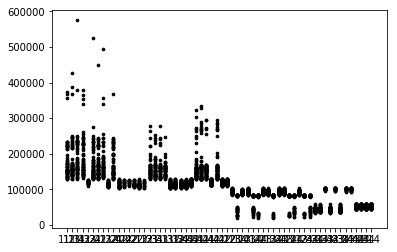

In [44]:
f1 = rfmTable['recent'].values
f2 = rfmTable['RCSClass'].values
f3=rfmTable['spent'].values
X = np.array(list(zip(f2,f3)))
plt.scatter(f2,f3, c='black', s=7)

In [45]:
def dist(a, b, ax=1):
    return np.linalg.norm(a - b, axis=ax)

In [48]:
from sklearn.cluster import KMeans

# Number of clusters
kmeans = KMeans(n_clusters=3)
# Fitting the input data
kmeans = kmeans.fit(X)
# Getting the cluster labels
labels = kmeans.predict(X)
# Centroid values
centroids = kmeans.cluster_centers_

In [49]:
print(centroids) 

[[  2.48370048e+02   7.49357145e+04]
 [  3.13081790e+02   1.31794487e+05]
 [  2.30326923e+02   2.48905918e+05]]


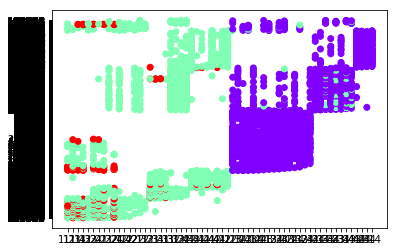

In [52]:
plt.scatter(X[:,0], X[:,1], c=kmeans.labels_, cmap='rainbow')